```
1. Importa las librerías necesarias y la base de datos, y realiza un análisis por variable
usando visualizaciones. Debes considerar las posibles correlaciones y representarlas
en un heatmap.

```

             Churn  AccountWeeks  ContractRenewal     DataPlan    DataUsage  \
count  3333.000000   3333.000000      3333.000000  3333.000000  3333.000000   
mean      0.144914    101.064806         0.903090     0.276628     0.816475   
std       0.352067     39.822106         0.295879     0.447398     1.272668   
min       0.000000      1.000000         0.000000     0.000000     0.000000   
25%       0.000000     74.000000         1.000000     0.000000     0.000000   
50%       0.000000    101.000000         1.000000     0.000000     0.000000   
75%       0.000000    127.000000         1.000000     1.000000     1.780000   
max       1.000000    243.000000         1.000000     1.000000     5.400000   

       CustServCalls      DayMins     DayCalls  MonthlyCharge   OverageFee  \
count    3333.000000  3333.000000  3333.000000    3333.000000  3333.000000   
mean        1.562856   179.775098   100.435644      56.305161    10.051488   
std         1.315491    54.467389    20.069084      16

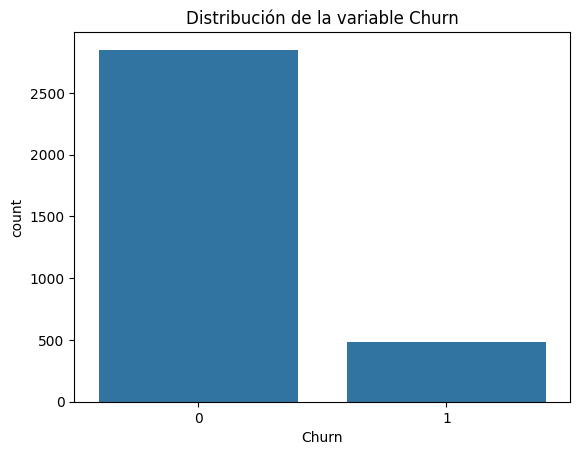

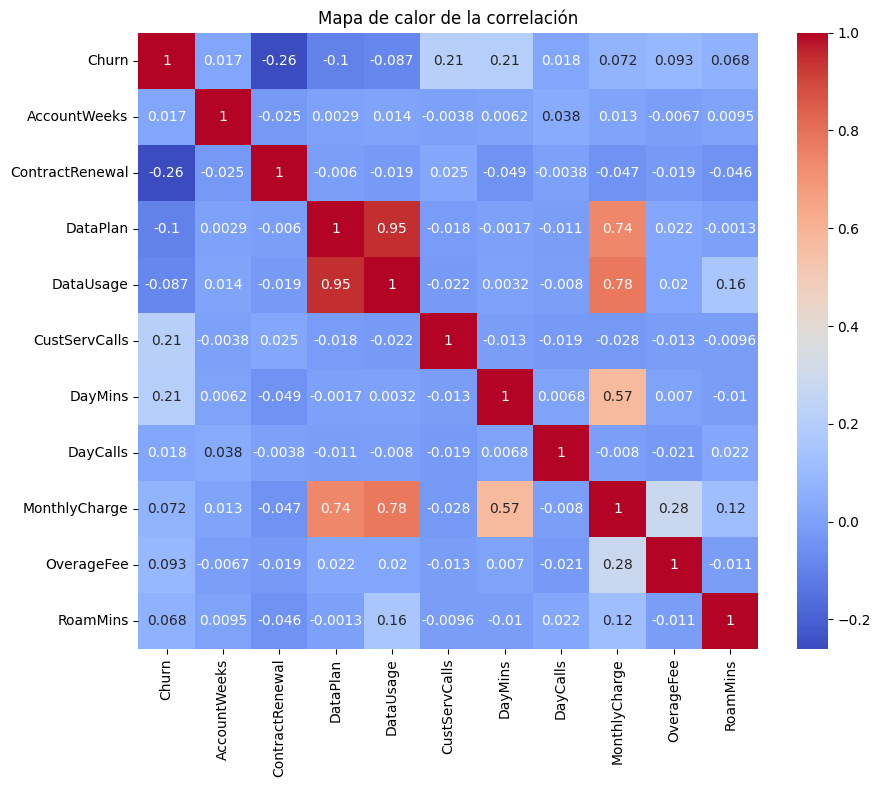

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    make_scorer,
)
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from util_bagging import bagging_het

# Cargar los datos
df = pd.read_csv("telecom_churn.csv")

# Contar valores ausentes
[(col, df[col].isnull().sum()) for col in df.columns]

# Análisis descriptivo
print(df.describe())

# Visualización de la variable objetivo
sns.countplot(x="Churn", data=df)
plt.title("Distribución de la variable Churn")
plt.show()

# Visualización de la correlación entre variables
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Mapa de calor de la correlación")
plt.show()

```
2. Desarrolla un modelo de árbol de decisión sin modificar sus hiper parámetros y
despliega sus métricas de desempeño. Luego, mejora este modelo de forma de
evitar el overfitting usando búsqueda por grilla con 5 kfold:
max_depth: [5, 10, 15, 20, 25]
min_samples_split: [0.01, 0.02, 0.03, 0.04]
Da a conocer los mejores hiper parámetros encontrados y el desempeño del modelo,
tanto en los datos de entrenamiento como en los de test.

```


In [36]:
RSTATE = 23124

# Separar características y variable objetivo
X = df.drop("Churn", axis=1)
y = df["Churn"]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=RSTATE
)

# Entrenar el modelo de Árbol de Decisión básico
dt = DecisionTreeClassifier(random_state=RSTATE)
dt.fit(X_train, y_train)

# Predicción y evaluación del modelo básico
y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)

print("\n---\nConjunto de entrenamiento")
print(classification_report(y_train, y_pred_train))
print("\n---\nConjunto de prueba")
print(classification_report(y_test, y_pred_test))

# Mejora del modelo usando Grid Search
param_grid = {
    "max_depth": [5, 10, 15, 20, 25],
    "min_samples_split": [0.01, 0.02, 0.03, 0.04],
}

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=RSTATE),
    param_grid=param_grid,
    cv=5,
    scoring="f1_macro",
)
grid_search.fit(X_train, y_train)

# Mejor modelo de Árbol de Decisión
best_dt = grid_search.best_estimator_

# Predicción y evaluación del mejor modelo
y_pred_best_train = best_dt.predict(X_train)
y_pred_best_test = best_dt.predict(X_test)

print("Best Parameters:", grid_search.best_params_)
print("\n---\nConjunto de entrenamiento (mejorado)")
print(classification_report(y_train, y_pred_best_train))
print("\n---\nConjunto de prueba (mejorado)")
print(classification_report(y_test, y_pred_best_test))


---
Conjunto de entrenamiento
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1917
           1       1.00      1.00      1.00       316

    accuracy                           1.00      2233
   macro avg       1.00      1.00      1.00      2233
weighted avg       1.00      1.00      1.00      2233


---
Conjunto de prueba
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       933
           1       0.72      0.59      0.65       167

    accuracy                           0.90      1100
   macro avg       0.83      0.78      0.80      1100
weighted avg       0.90      0.90      0.90      1100

Best Parameters: {'max_depth': 5, 'min_samples_split': 0.02}

---
Conjunto de entrenamiento (mejorado)
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      1917
           1       0.88      0.63      0.73       316

    accuracy            

```
3. Balancea las clases usando SMOTE para el conjunto de entrenamiento. Luego, aplica
un modelo de Bagging con 200 estimadores y muestra las métricas sobre el conjunto
de test

```

In [37]:
# Balanceo de clases usando SMOTE
smote = SMOTE(random_state=RSTATE)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Modelo de Bagging
bagging = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(),
    n_estimators=200,
    random_state=RSTATE,
    n_jobs=-1,
    oob_score=True,
)
bagging.fit(X_train_bal, y_train_bal)

# Evaluación del modelo de Bagging
y_pred_bagging = bagging.predict(X_test)
print("\n---\nModelo de Bagging")
print(classification_report(y_test, y_pred_bagging))
print("OOB Score:", bagging.oob_score_)


---
Modelo de Bagging
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       933
           1       0.67      0.77      0.71       167

    accuracy                           0.91      1100
   macro avg       0.81      0.85      0.83      1100
weighted avg       0.91      0.91      0.91      1100

OOB Score: 0.9327073552425665


```
4. Implementa un modelo de Bagging usando modelos heterogéneos con los
siguientes estimadores: Regresión Logística, Árbol de decisión, y dos SVM de
clasificación con kernel ‘rbf’ y ‘sigmoid’. Para ello considera 200 muestras bootstrap
(T).
Debes calibrar la importancia de los modelos, repitiendo el modelo que sea más
importante en la lista de modelos a entrenar. Considera que un mejor modelo es
aquel con mejor f1-score. Muestra las métricas del modelo final aplicado al conjunto
de test. (Para realizar esta tarea utiliza la función bagging_het que se encuentra en el
archivo util_bagging.py)

```

In [38]:
# Definir los modelos heterogéneos
estimators = [
    LogisticRegression(max_iter=1000),
    DecisionTreeClassifier(),
    SVC(kernel="rbf", probability=True),
    SVC(kernel="sigmoid", probability=True),
]

# Entrenar el modelo de Bagging heterogéneo
T = 200
trained_models, yhat_test, yhat_out, idx_oob = bagging_het(
    X_train_bal, y_train_bal, T, estimators, X_test
)

# Evaluar el modelo en el conjunto de prueba
print("\n---\nModelo de Bagging heterogéneo")
print(classification_report(y_test, yhat_out))
print("Bagging Heterogeneous Accuracy:", accuracy_score(y_test, yhat_out))


---
Modelo de Bagging heterogéneo
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       933
           1       0.55      0.66      0.60       167

    accuracy                           0.87      1100
   macro avg       0.74      0.78      0.76      1100
weighted avg       0.88      0.87      0.87      1100

Bagging Heterogeneous Accuracy: 0.8672727272727273


```
5. Implementa un modelo de ensamble Random Forest usando como hiper parámetro
n_estimators = 45. El modelo debe usar muestra OOB para estimar su ajuste
ACCURACY, y debe mostrar las cuatro características más importantes junto con las
métricas de desempeño en el conjunto de test.


```


---
Random Forest
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       933
           1       0.69      0.75      0.72       167

    accuracy                           0.91      1100
   macro avg       0.82      0.84      0.83      1100
weighted avg       0.91      0.91      0.91      1100

OOB Score: 0.9300991131977048


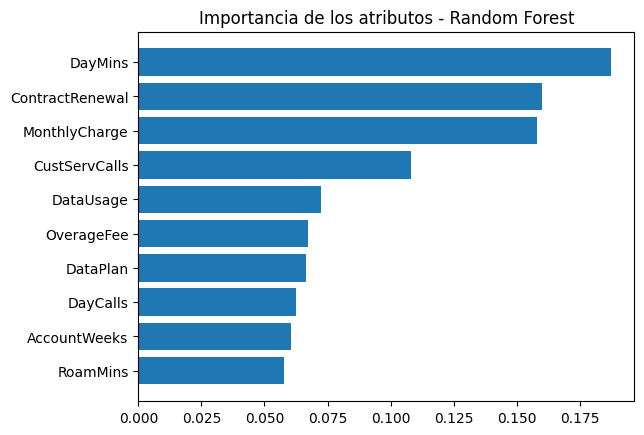

In [39]:
# Modelo de Random Forest
rf = RandomForestClassifier(n_estimators=45, oob_score=True, random_state=RSTATE)
rf.fit(X_train_bal, y_train_bal)

# Evaluación del modelo de Random Forest
y_pred_rf = rf.predict(X_test)
print("\n---\nRandom Forest")
print(classification_report(y_test, y_pred_rf))
print("OOB Score:", rf.oob_score_)

# Visualizar la importancia de los atributos del modelo
idx_sort = np.argsort(rf.feature_importances_)
plt.barh(y=rf.feature_names_in_[idx_sort], width=rf.feature_importances_[idx_sort])
plt.title("Importancia de los atributos - Random Forest")
plt.show()

```  
6. Realiza una búsqueda de grilla para un modelo Random Forest para los siguientes
rangos de valores para sus hiper parámetros:
n_estimators: 50 - 200 con paso de 10 completando 15 valores
max_features: [‘sqrt’, ‘log2’, None]

Muestra los mejores hiper parámetros encontrados, la estimación de desempeño en
los datos OOB, y despliega los cuatro atributos más importantes. ¿Tienen sentido
estos? Analiza además las métricas de desempeño, ROC y AUC.

```


---
Mejor Random Forest
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       933
           1       0.69      0.75      0.72       167

    accuracy                           0.91      1100
   macro avg       0.82      0.84      0.83      1100
weighted avg       0.91      0.91      0.91      1100

Mejores hiperparámetros: {'max_features': 'sqrt', 'n_estimators': 50}
OOB Score: 0.9300991131977048


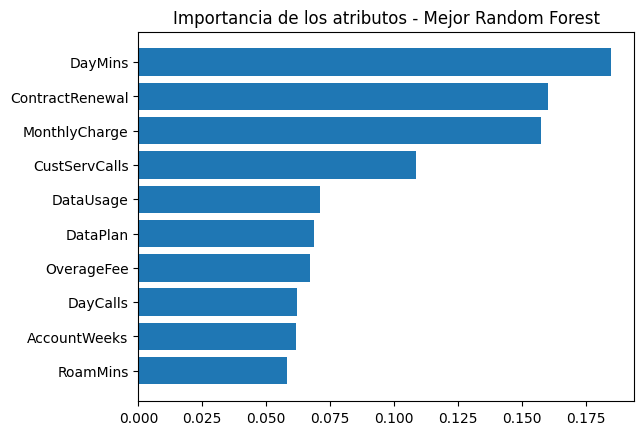

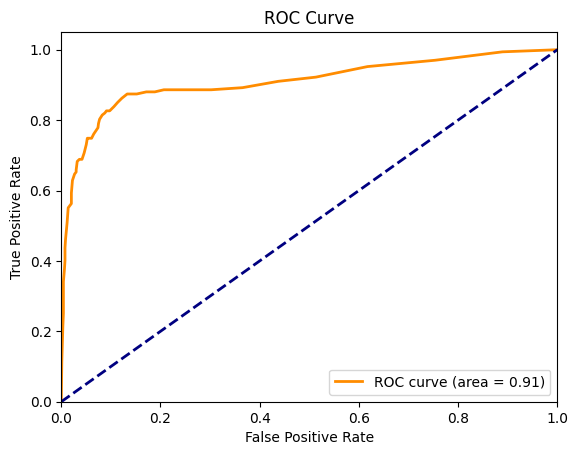

In [41]:
param_grid_rf = {
    "n_estimators": range(50, 201, 10),
    "max_features": ["sqrt", "log2", None],
}

grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(oob_score=True, random_state=RSTATE),
    param_grid=param_grid_rf,
    cv=5,
    scoring=make_scorer(f1_score, average="macro"),
)
grid_search_rf.fit(X_train_bal, y_train_bal)

# Mejor modelo de Random Forest
best_rf = grid_search_rf.best_estimator_

# Evaluación del mejor modelo en los datos de prueba
y_pred_best_rf = best_rf.predict(X_test)
print("\n---\nMejor Random Forest")
print(classification_report(y_test, y_pred_best_rf))
print("Mejores hiperparámetros:", grid_search_rf.best_params_)
print("OOB Score:", best_rf.oob_score_)

# Visualizar la importancia de los atributos del mejor Random Forest
idx_sort = np.argsort(best_rf.feature_importances_)
plt.barh(
    y=best_rf.feature_names_in_[idx_sort], width=best_rf.feature_importances_[idx_sort]
)
plt.title("Importancia de los atributos - Mejor Random Forest")
plt.show()

# Curva ROC y AUC
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba_rf)
roc_auc = roc_auc_score(y_test, y_proba_rf)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

```
7. Usando el modelo Random Forest con sus hiper parámetros ajustados, muestre los
15 clientes que presentan la mayor propensión a renunciar.
```

In [43]:
# Predecir las probabilidades de renuncia
probs = best_rf.predict_proba(X)[:, 1]

# Añadir las probabilidades al dataframe original
df["Churn_Probability"] = probs

# Mostrar los 15 clientes con mayor probabilidad de renunciar
top_15_customers = df.nlargest(15, "Churn_Probability")
top_15_customers

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins,Churn_Probability
21,1,77,1,0,0.00,5,62.4,89,26.0,8.50,5.7,1.0
41,1,135,0,1,3.94,0,173.1,85,86.4,10.20,14.6,1.0
86,1,94,1,0,0.00,4,157.9,105,41.0,7.75,8.0,1.0
115,1,36,0,1,5.40,0,196.8,89,110.0,12.75,20.0,1.0
117,1,74,1,0,0.21,1,282.5,114,69.1,11.00,9.4,1.0
126,1,162,1,0,0.00,4,70.7,108,26.0,7.88,9.1,1.0
144,1,117,0,0,0.00,2,167.1,86,44.0,8.88,14.1,1.0
181,1,126,1,0,0.00,5,58.2,94,22.0,6.94,11.9,1.0
218,1,136,1,0,0.00,1,250.2,121,66.0,13.36,13.0,1.0
235,1,139,1,0,0.00,5,134.4,106,41.0,10.57,10.2,1.0
